# Phase d'expérimentation - Car Price Prediction



###### Ce Notebook présente comment entraîner un Random Forest qui cherche à prédire le prix de vente d'une voiture en fonction de ses caractéristiques.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#importing the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 

import pycaret 
import mlflow 

import mlflow.sklearn #Wrapper pour scikit-learn 


In [2]:
os.getcwd()

'C:\\Users\\inno-demo\\Documents\\MLOPS\\Notebooks'

In [3]:
#os.chdir('C:\\Users\\Admin\\Documents\\Template-Flask-Scikit-Learn')
cars = pd.read_csv('cars.csv')
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Nettoyage du jeu de données

In [4]:
# On remplace CarName par le nom de l'entreprise (premier mot dans CarName)
companies = cars['CarName'].apply(lambda x : x.split(' ')[0])
cars.insert(3, "companies", companies)
cars.drop(['CarName'], axis=1, inplace=True)

cars.companies = cars.companies.str.lower()

def replace_name(a,b):
    cars.companies.replace(a,b,inplace=True)

# On remplace certaines occurrences identiques
replace_name('maxda','mazda')
replace_name('porcshce','porsche')
replace_name('toyouta','toyota')
replace_name('vokswagen','volkswagen')
replace_name('vw','volkswagen')

cars.companies.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
       'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
       'subaru', 'toyota', 'volkswagen', 'volvo'], dtype=object)

In [5]:
# Y a-t-il des doublons ?
cars.loc[cars.duplicated()].shape

(0, 26)

In [6]:
cars['fueleconomy'] = (0.55 * cars['citympg']) + (0.45 * cars['highwaympg'])

# On converti le prix en entiers
cars['price'] = cars['price'].astype('int')

# On calcule le prix moyen par entreprise que l'on met dans une table temporaire
temp = cars.copy()
avg_price = temp.groupby(['companies'])['price'].mean()
temp = temp.merge(avg_price.reset_index(), how='left',on='companies')
temp.head()

,car_ID,symboling,companies,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price_x,fueleconomy,price_y
0,1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000,21,27,13495,23.70,15498.333333
1,2,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000,21,27,16500,23.70,15498.333333
2,3,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,2.68,3.47,9.0,154,5000,19,26,16500,22.15,15498.333333
3,4,2,audi,gas,std,four,sedan,fwd,front,99.8,...,3.19,3.40,10.0,102,5500,24,30,13950,26.70,17859.142857
4,5,2,audi,gas,std,four,sedan,4wd,front,99.4,...,3.19,3.40,8.0,115,5500,18,22,17450,19.80,17859.142857


In [7]:
# On enregistre les prix moyens
avg_price.to_csv("avg_price.csv")
avg_price

companies
alfa-romero    15498.333333
audi           17859.142857
bmw            26118.750000
buick          33647.000000
chevrolet       6007.000000
dodge           7875.444444
honda           8184.692308
isuzu           8916.250000
jaguar         34600.000000
mazda          10652.882353
mercury        16503.000000
mitsubishi      9239.769231
nissan         10415.666667
peugeot        15489.090909
plymouth        7963.428571
porsche        31400.400000
renault         9595.000000
saab           15223.333333
subaru          8541.250000
toyota          9885.812500
volkswagen     10077.500000
volvo          18063.181818
Name: price, dtype: float64

In [8]:
# On calcule ensuite un ordre de prix pour l'entreprise
bins = [0, 10000, 20000, 40000]
cars_bin = ['cheap', 'medium', 'high']
cars['company_price'] = pd.cut(temp['price_y'], bins, right=False, labels=cars_bin)
cars.head()

,car_ID,symboling,companies,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,fueleconomy,company_price
0,1,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000,21,27,13495,23.70,medium
1,2,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,3.47,2.68,9.0,111,5000,21,27,16500,23.70,medium
2,3,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,2.68,3.47,9.0,154,5000,19,26,16500,22.15,medium
3,4,2,audi,gas,std,four,sedan,fwd,front,99.8,...,3.19,3.40,10.0,102,5500,24,30,13950,26.70,medium
4,5,2,audi,gas,std,four,sedan,4wd,front,99.4,...,3.19,3.40,8.0,115,5500,18,22,17450,19.80,medium


In [9]:
# On sélectionne notre jeu de données prêt à l'encodage
primary = cars[[
  'price', 'fueltype', 'aspiration','carbody', 'drivewheel','wheelbase',
  'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 
  'fueleconomy', 'carlength','carwidth', 'company_price'
]]
primary.head()

,price,fueltype,aspiration,carbody,drivewheel,wheelbase,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,fueleconomy,carlength,carwidth,company_price
0,13495,gas,std,convertible,rwd,88.6,2548,dohc,four,130,3.47,111,23.70,168.8,64.1,medium
1,16500,gas,std,convertible,rwd,88.6,2548,dohc,four,130,3.47,111,23.70,168.8,64.1,medium
2,16500,gas,std,hatchback,rwd,94.5,2823,ohcv,six,152,2.68,154,22.15,171.2,65.5,medium
3,13950,gas,std,sedan,fwd,99.8,2337,ohc,four,109,3.19,102,26.70,176.6,66.2,medium
4,17450,gas,std,sedan,4wd,99.4,2824,ohc,five,136,3.19,115,19.80,176.6,66.4,medium


# Encodage des variables

In [10]:
def dummies(col, df):
    temp = pd.get_dummies(df[col], prefix=col, drop_first = True)
    df = pd.concat([df, temp], axis=1)
    df.drop([col], axis=1, inplace=True)
    return df, temp.columns.values

dummy_cols = [
    "fueltype", "aspiration", "carbody", "drivewheel",
    "enginetype", "cylindernumber", "company_price"
]

new_dummies_cols = []

for col in dummy_cols:
  primary, new_cols = dummies(col, primary)
  new_dummies_cols += list(new_cols)

with open("dummies_cols.txt", "w") as f:
  f.write(",".join(new_dummies_cols))

primary.head()

,price,wheelbase,curbweight,enginesize,boreratio,horsepower,fueleconomy,carlength,carwidth,fueltype_gas,...,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,company_price_medium,company_price_high
0,13495,88.6,2548,130,3.47,111,23.70,168.8,64.1,1,...,0,0,0,1,0,0,0,0,1,0
1,16500,88.6,2548,130,3.47,111,23.70,168.8,64.1,1,...,0,0,0,1,0,0,0,0,1,0
2,16500,94.5,2823,152,2.68,154,22.15,171.2,65.5,1,...,1,0,0,0,1,0,0,0,1,0
3,13950,99.8,2337,109,3.19,102,26.70,176.6,66.2,1,...,0,0,0,1,0,0,0,0,1,0
4,17450,99.4,2824,136,3.19,115,19.80,176.6,66.4,1,...,0,0,1,0,0,0,0,0,1,0


In [11]:
# On enregistre le dataset ici pour une utilisation ultérieure dans l'app 
primary.to_csv("primary.csv")


In [12]:
from sklearn.model_selection import train_test_split

np.random.seed(0)

X = primary.drop("price", axis=1)
y = primary["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [24]:
X_train.head()

,wheelbase,curbweight,enginesize,boreratio,horsepower,fueleconomy,carlength,carwidth,fueltype_gas,aspiration_turbo,...,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,company_price_medium,company_price_high
122,93.7,2191,98,2.97,68,34.15,167.3,63.8,1,0,...,0,0,0,1,0,0,0,0,0,0
125,94.5,2778,151,3.94,143,22.60,168.9,68.3,1,0,...,0,0,0,1,0,0,0,0,0,1
166,94.5,2300,98,3.24,112,27.35,168.7,64.0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,88.6,2548,130,3.47,111,23.70,168.8,64.1,1,0,...,0,0,0,1,0,0,0,0,1,0
199,104.3,3157,130,3.62,162,19.25,188.8,67.2,1,1,...,0,0,0,1,0,0,0,0,1,0


In [13]:
X_train.columns.values

array(['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower',
       'fueleconomy', 'carlength', 'carwidth', 'fueltype_gas',
       'aspiration_turbo', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three',
       'cylindernumber_twelve', 'cylindernumber_two',
       'company_price_medium', 'company_price_high'], dtype=object)

# Construction du modèle

In [14]:
# Identification de l'interface MLflow 

import mlflow 

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mlflow_demo_2")

In [15]:
mlflow.get_tracking_uri()

'http://127.0.0.1:5000'

In [17]:
os.getcwd()

'C:\\Users\\inno-demo\\Documents\\MLOPS\\Notebooks'

In [16]:
avg_price_path = "C:\\Users\\inno-demo\\Documents\\MLOPS\\Notebooks\\avg_price.csv"
dummies_col_path = "C:\\Users\\inno-demo\\Documents\\MLOPS\\Notebooks\\dummies_cols.txt"

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
hparams = {
    "n_estimators": 400,
    "max_depth": 12,
    "max_samples": 0.8,
    "max_features": "auto"
}
with mlflow.start_run() as run:
    rf = RandomForestRegressor(**hparams)
    rf.fit(X_train, y_train)
    
    print("Score train : {:2.1f}%".format(r2_score(y_train, rf.predict(X_train)) * 100))
    print("Score test : {:2.1f}%".format(r2_score(y_test, rf.predict(X_test)) * 100))
    
    mlflow.log_params(hparams)
    mlflow.log_metric("r2" , r2_score(y_test, rf.predict(X_test)))
    
   
    mlflow.log_artifact(avg_price_path  , "process")
    mlflow.log_artifact(dummies_col_path , "process")
    print("Save to {}".format(mlflow.get_artifact_uri()))
    
    mlflow.sklearn.log_model(rf , "model")

Score train : 98.5%
Score test : 91.1%
Save to ./mlruns/1/4e05305ec88e4e79b71ee975c3f46524/artifacts


In [29]:
mlflow.list_run_infos("4")[0].run_id

'fb1c8cc1cbfa4ee0ae085b1f4ded0a92'

In [26]:
from sklearn.metrics import r2_score

print("Score train : {:2.1f}%".format(r2_score(y_train, rf.predict(X_train)) * 100))
print("Score test : {:2.1f}%".format(r2_score(y_test, rf.predict(X_test)) * 100))

NameError: name 'rf' is not defined

In [17]:
import joblib

joblib.dump(rf, "model.pkl")

['model.pkl']

In [31]:
!python -V

Python 3.7.9


In [28]:
sample = pd.read_csv("cars.csv").sample(10)

# Encapsulation des transformations

In [29]:
import re

COMPANIES = [
  'alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
  'isuzu', 'jaguar', 'mazda', 'buick', 'mercury', 'mitsubishi',
  'nissan', 'peugeot', 'plymouth', 'porsche', 'renault', 'saab',
  'subaru', 'toyota', 'volkswagen', 'volvo'
]
TRUE_COLUMNS = ['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower',
       'fueleconomy', 'carlength', 'carwidth', 'fueltype_gas',
       'aspiration_turbo', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three',
       'cylindernumber_twelve', 'cylindernumber_two',
       'company_price_medium', 'company_price_high']

avg_price = pd.read_csv("avg_price.csv")
with open("dummies_cols.txt", "r") as f:
  dummies = f.read().split(",")

def transform(data):
  X = data.copy()
  companies = X['CarName'].apply(lambda x : x.split(' ')[0])
  X.insert(3, "companies", companies)
  X.drop(['CarName'], axis=1, inplace=True)

  X.companies = X.companies.str.lower()

  def replace_name(a,b):
      X.companies.replace(a,b,inplace=True)

  # On remplace certaines occurrences identiques
  replace_name('maxda','mazda')
  replace_name('porcshce','porsche')
  replace_name('toyouta','toyota')
  replace_name('vokswagen','volkswagen')
  replace_name('vw','volkswagen')

  X['fueleconomy'] = (0.55 * X['citympg']) + (0.45 * X['highwaympg'])

  temp = X.copy()
  temp = temp.merge(avg_price.reset_index(), how='left', on='companies')

  bins = [0, 10000, 20000, 40000]
  cars_bin = ['cheap', 'medium', 'high']
  X['company_price'] = pd.cut(temp['price_y'], bins, right=False, labels=cars_bin)
  X.head()

  X = X[[
    'price', 'fueltype', 'aspiration','carbody', 'drivewheel','wheelbase',
    'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 
    'fueleconomy', 'carlength','carwidth', 'company_price'
  ]]

  for dummy in dummies:
    X[dummy] = 0

  dummy_cols = [
      "fueltype", "aspiration", "carbody", "drivewheel",
      "enginetype", "cylindernumber", "company_price"
  ]

  def replace_dummies(col, df):
    temp = pd.get_dummies(df[col], prefix=col, drop_first = True)
    #df = pd.concat([df, temp], axis=1)
    # lsuffix nous indique les colonnes à retirer
    df = df.join(temp, lsuffix="_toremove")
    df.drop([col], axis=1, inplace=True)
    for colname in df.columns.values:
      if re.search(r"_toremove", colname):
        df.drop([colname], axis=1, inplace=True)
    return df

  for dummy in dummy_cols:
    X = replace_dummies(dummy, X)

  return X[TRUE_COLUMNS]

psample = transform(sample)

In [30]:
psample.head(5)

,wheelbase,curbweight,enginesize,boreratio,horsepower,fueleconomy,carlength,carwidth,fueltype_gas,aspiration_turbo,...,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,company_price_medium,company_price_high
52,93.1,1905,91,3.03,68,34.15,159.1,64.2,0,0,...,0,0,0,1,0,0,0,0,0,0
181,104.5,3151,161,3.27,156,21.25,187.8,66.5,0,0,...,0,0,0,0,1,0,0,0,0,0
5,99.8,2507,136,3.19,110,21.70,177.3,66.3,0,0,...,0,0,0,0,0,0,0,0,0,0
18,88.4,1488,61,2.91,48,49.70,141.1,60.3,0,0,...,0,0,0,0,0,1,0,0,0,0
188,97.3,2300,109,3.19,100,28.70,171.7,65.5,0,0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
rf.predict(psample)

NameError: name 'rf' is not defined

# PYCARET & MLFLOW 

In [17]:
# initialize setup
from pycaret.regression import *
s = setup(primary, target = 'price', transform_target = True, log_experiment = True, experiment_name = 'car_price2')

,Description,Value
0,session_id,3453
1,Target,price
2,Original Data,"(205, 31)"
3,Missing Values,False
4,Numeric Features,30
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(143, 29)"


In [18]:
# compare all models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1486.1560,4989731.8026,2170.0470,0.9083,0.1351,0.1020,0.1220
gbr,Gradient Boosting Regressor,1523.2465,4891986.0092,2149.0275,0.8978,0.1445,0.1080,0.0200
catboost,CatBoost Regressor,1578.5772,5620969.6141,2309.9848,0.8972,0.1402,0.1073,0.8690
rf,Random Forest Regressor,1538.9194,5032152.1261,2188.9856,0.8944,0.1444,0.1074,0.1430
ada,AdaBoost Regressor,1613.6831,5757586.7775,2267.5221,0.8906,0.1466,0.1127,0.0260
xgboost,Extreme Gradient Boosting,1709.1651,5887454.6544,2410.9008,0.8763,0.1659,0.1243,0.1770
dt,Decision Tree Regressor,1998.1072,7901946.2175,2759.8928,0.8419,0.1837,0.1423,0.0080
lightgbm,Light Gradient Boosting Machine,2062.7251,11603089.0187,3258.1717,0.8046,0.1775,0.1297,0.0140
knn,K Neighbors Regressor,2610.2138,18169339.4038,3983.5254,0.7214,0.2270,0.1681,0.0280
ridge,Ridge Regression,2751.2557,34402893.1680,5174.2746,0.4380,0.1931,0.1525,0.0090


In [19]:
best

PowerTransformedTargetRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                                max_depth=None, max_features='auto',
                                max_leaf_nodes=None, max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_jobs=-1, oob_score=False,
                                power_transformer_method='box-cox',
                                powe...
                                regressor=ExtraTreesRegressor(bootstrap=False,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                             

In [20]:
# check the residuals of trained model
plot_model(best, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

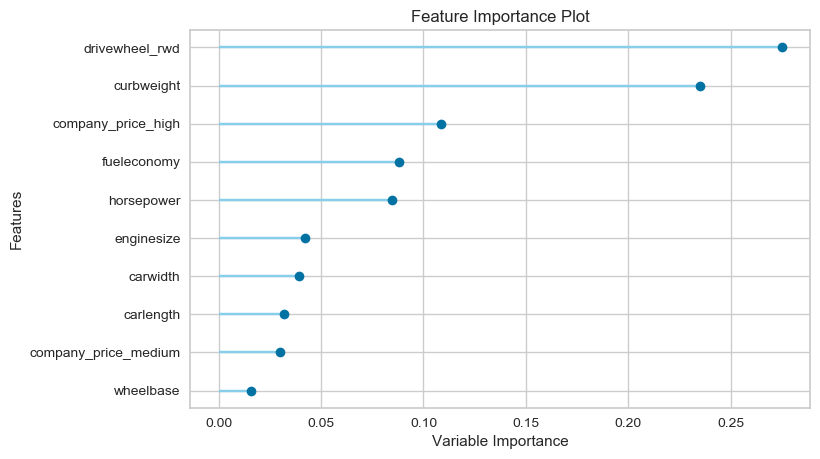

In [21]:
# check feature importance
plot_model(best, plot = 'feature')

In [22]:
# finalize the model
final_best = finalize_model(best)
# save model to disk
save_model(final_best, 'car2-pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='price',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                                                                                ccp_alpha=0.0,
                                                                                criterion='mse',
                                                                                max_depth=None,
                         

In [23]:
# load model
from pycaret.regression import load_model

pipeline = load_model('C:\\Users\\inno-demo\\Documents\\MLOPS\\Notebooks\\mlruns\\9\\f4c60a87d5f643dfa7037f4b63177274\\artifacts\\model\\model')
# print pipeline
print(pipeline)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='price',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                                                                               ccp_alpha=0.0,
                                                                               criterion='mse',
                                                                               ma

In [25]:

from pycaret.regression import predict_model
predictions = predict_model(pipeline, data=primary)
predictions.head()

,price,wheelbase,curbweight,enginesize,boreratio,horsepower,fueleconomy,carlength,carwidth,fueltype_gas,...,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,company_price_medium,company_price_high,Label
0,13495,88.6,2548,130,3.47,111,23.70,168.8,64.1,1,...,0,0,1,0,0,0,0,1,0,14874.803222
1,16500,88.6,2548,130,3.47,111,23.70,168.8,64.1,1,...,0,0,1,0,0,0,0,1,0,14874.803222
2,16500,94.5,2823,152,2.68,154,22.15,171.2,65.5,1,...,0,0,0,1,0,0,0,1,0,16500.000000
3,13950,99.8,2337,109,3.19,102,26.70,176.6,66.2,1,...,0,0,1,0,0,0,0,1,0,13950.000000
4,17450,99.4,2824,136,3.19,115,19.80,176.6,66.4,1,...,0,1,0,0,0,0,0,1,0,17450.000000


# Tester l'api en ligne 

'http://127.0.0.1:8502/predict'